# Functions to be called throughout the code

In [1]:
def standardize(parameter):
    """
    :param parameter: the array with the parameters you wish to standardize
    :return param_mean: mean of the input array
    :return param_std : standard deviation of the input array
    :return stdized_param: final standardized array
    """
    import numpy as np
    
    param_mean    = np.mean(parameter)
    param_std     = np.std(parameter)
    stdized_param = []                  # standardized parameter -- output
    for i in range(parameter.size):
        param_temp = (parameter[i] - param_mean)/param_std
        stdized_param.append(param_temp)
    stdized_param = np.array(stdized_param)
    return (param_mean, param_std, stdized_param)

In [2]:
def un_standardize(stdized_par, mean, std):
    """
    This function undoes what the former does!
    """
    
    import numpy as np
    
    recovered_par = []
    for i in range(stdized_par.size):
        param_temp = stdized_par[i]*std + mean
        recovered_par.append(param_temp)
    recovered_par = np.array(recovered_par)
    return (recovered_par)

# Libraries

In [3]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import statsmodels.api   as sm
import seaborn           as sns
import pystan
import time

# Configuring the regression parameters

In [4]:
my_data = pd.read_csv('../../../../Catalogue/binom_reg_dataset.csv')

In [5]:
# filtering the dataset
redshifts = my_data['Z']
index     = np.where(redshifts.values<=0.4)

# parameters of interest
# logit_class = my_data['LOGIT_CLASS(1-UVUP;0-UVWEAK)'].values[index].astype(int)    # y axis: logit class: UVUP yes/no
# whan_class  = my_data['WHAN(0-NA;1-RP;2-wA;3-sA;4-SF)'].values[index].astype(int)  # My types of galaxies
# mass        = my_data['STELLAR_MASS'].values[index].astype(int)                    # 1st parameter
# redshift    = redshifts.values[index].astype(float)                                # 2nd parameter

logit_class = my_data['LOGIT_CLASS(1-UVUP;0-UVWEAK)'].values.astype(int)    # y axis: logit class: UVUP yes/no
whan_class  = my_data['WHAN(0-NA;1-RP;2-wA;3-sA;4-SF)'].values.astype(int)  # My types of galaxies
mass        = my_data['STELLAR_MASS'].values.astype(int)                    # 1st parameter
redshift    = redshifts.values.astype(float)                                # 2nd parameter

In [6]:
# original parameters
mean_mass, std_mass, x2 = standardize(mass)
x1      = redshift
y       = logit_class
classes = (whan_class+1).astype(int)        # Must sum +1 to avoid index issues with STAN
n_obs   = x1.size
n_class = np.unique(classes).size

# new parameters - important for plotting!
n_obs2 = 30
x1_sim = np.linspace(x1.min(), x1.max(), n_obs2)
x2_sim = np.linspace(x2.min(), x2.max(), n_obs2)

# grid
plot_x1, plot_x2 = np.meshgrid(x1_sim, x2_sim)  # THIS IS WHERE THE GRID IS DONE
plot_x1 = plot_x1.reshape((n_obs2**2), 1)
plot_x2 = plot_x2.reshape((n_obs2**2), 1)

In [7]:
plot_x1.shape

(900, 1)

In [8]:
print x2.min(), x2.max() # sanity check
print np.median(x2)
print plot_x1.shape

-2.584017637065887 1.5734161446681023
-0.5053007461988924
(900, 1)


In [9]:
# dataset to be used in the regression
regression_data      = {}                                                 # Dictionary, as stated in the pystan manual
regression_data['Y'] = y
regression_data['X'] = sm.add_constant(np.column_stack((x1, x1**2, x2, x2**2)))
regression_data['K'] = regression_data['X'][0,:].size                     # Number of betas -- b0, b1, b2, b3, b4
regression_data['W'] = classes
regression_data['N'] = n_obs
regression_data['C'] = n_class                                       # Number of different classes (partial pooling)

# dataset to be used in the plot -- after meshgrid
regression_data['X2'] = sm.add_constant(np.column_stack((plot_x1, plot_x1**2, plot_x2, plot_x2**2)))
regression_data['N2'] = n_obs2**2

In [10]:
print (regression_data['X2'][899,4])

2.4756383643022346


In [11]:
print (regression_data['X2'])

[[ 1.00000000e+00  6.79400000e-02  4.61584360e-03 -2.58401764e+00
   6.67714715e+00]
 [ 1.00000000e+00  8.48886207e-02  7.20607792e-03 -2.58401764e+00
   6.67714715e+00]
 [ 1.00000000e+00  1.01837241e-01  1.03708237e-02 -2.58401764e+00
   6.67714715e+00]
 ...
 [ 1.00000000e+00  5.25552759e-01  2.76205702e-01  1.57341614e+00
   2.47563836e+00]
 [ 1.00000000e+00  5.42501379e-01  2.94307747e-01  1.57341614e+00
   2.47563836e+00]
 [ 1.00000000e+00  5.59450000e-01  3.12984302e-01  1.57341614e+00
   2.47563836e+00]]


In [12]:
print plot_x1.shape

(900, 1)


In [13]:
# Fit: STAN code ----------------------------------------------------------------------------------------------------------
stan_code = """
// DECLARATION OF VARIABLES -------------------------------------------------------------------------------------------
data{
    int<lower=1> N;
    int<lower=1> N2;
    int<lower=1> K;
    int<lower=1> C;
    int W[N];
    int<lower=0, upper=1> Y[N];
    matrix[N, K] X;         // redshift and stellar mass 
    matrix[N2,K] X2;        // redshift and stellar mass -- after grid
    }

// DEFINING THE PRIOR(S) --------------------------------------------------------------------------------------------------
parameters{
    matrix[K,C] beta;       // 25 betas!
    real<lower=0> sigma;    // Shared hyperpriors
    real mu;                // Shared hyperpriors
    }

// MODEL: PROBABILITY, HYPERPRIORS, PRIORS, AND REGRESSION ----------------------------------------------------------------
model {
   vector[N] prob;
    for (i in 1:N) {
      prob[i] = beta[1,W[i]]*X[i,1] + beta[2,W[i]]*X[i,2] + beta[3,W[i]]*X[i,3] + beta[4,W[i]]*X[i,4] + 
      beta[5,W[i]]*X[i,5];
      }

    sigma ~ gamma(0.001, 0.001);                           // shared hyperpriors
    mu ~ normal(0, 100);                                   // shared hyperpriors
     
    for (i in 1:K) {
       for (j in 1:C) beta[i,j] ~ normal(mu, sigma);       // priors
        }

    Y ~ bernoulli_logit(prob);                             // regression
    }

// DATA TO BE PLOTTED -----------------------------------------------------------------------------------------------------
generated quantities{
    vector[N2] prob01;
    vector[N2] eta01;
    vector[N2] prob02;
    vector[N2] eta02;
    vector[N2] prob03;
    vector[N2] eta03;
    vector[N2] prob04;
    vector[N2] eta04;
    vector[N2] prob05;
    vector[N2] eta05;
    
    for(j in 1:N2){
        eta01[j] = beta[1,1]*X2[j,1] + beta[2,1]*X2[j,2] + beta[3,1]*X2[j,3] + beta[4,1]*X2[j,4] + beta[5,1]*X2[j,5];
        eta02[j] = beta[1,2]*X2[j,1] + beta[2,2]*X2[j,2] + beta[3,2]*X2[j,3] + beta[4,2]*X2[j,4] + beta[5,2]*X2[j,5];
        eta03[j] = beta[1,3]*X2[j,1] + beta[2,3]*X2[j,2] + beta[3,3]*X2[j,3] + beta[4,3]*X2[j,4] + beta[5,3]*X2[j,5];
        eta04[j] = beta[1,4]*X2[j,1] + beta[2,4]*X2[j,2] + beta[3,4]*X2[j,3] + beta[4,4]*X2[j,4] + beta[5,4]*X2[j,5];
        eta05[j] = beta[1,5]*X2[j,1] + beta[2,5]*X2[j,2] + beta[3,5]*X2[j,3] + beta[4,5]*X2[j,4] + beta[5,5]*X2[j,5];
        prob01[j] = inv_logit(eta01[j]);
        prob02[j] = inv_logit(eta02[j]);
        prob03[j] = inv_logit(eta03[j]);
        prob04[j] = inv_logit(eta04[j]);
        prob05[j] = inv_logit(eta05[j]);
        }

    }

"""

### Settings for running STAN

In [14]:
iterations    = 2500
chains        = 3                           # HMC chains
warmup        = 500                       # How many of the first iterations we'll ignore - burnin
jobs          = -1                          # Run code in parallel -- see pystan documentation
seed          = 1

In [15]:
control = {}
control['max_treedepth'] = 20
control['adapt_delta'] = 0.99

### The fit:

In [16]:
start = time.time()

fit = pystan.stan(model_code=stan_code, data=regression_data, seed=seed, iter=iterations, chains=chains, warmup=warmup,
                  n_jobs=jobs, control=control)

end = time.time()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6630be1e6b20392f170fae3fd62a722c NOW.
/home/mlldantas/anaconda3/envs/py2k7/lib/python2.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpZ8RkWr/stanfit4anon_model_6630be1e6b20392f170fae3fd62a722c_8363174485963815141.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [17]:
print ("--------------------------------------------------")
print ("CPU process time: %.2f [min]" % float((end-start)/60))
print ("--------------------------------------------------")

--------------------------------------------------
CPU process time: 9.25 [min]
--------------------------------------------------


### Extracting fit properties

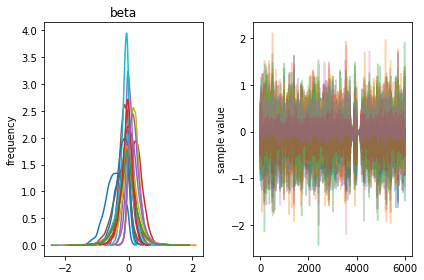

In [18]:
fit.plot('beta')
plt.tight_layout()
plt.show()

In [19]:
summary = pystan.stansummary(fit=fit, digits_summary=5)

In [20]:
summary_arr = np.array(summary.split('\n'))

In [21]:
new_output = summary_arr[5:-6,]                                                    # removing header and footer

In [22]:
print new_output[0]

beta[1,1]   -0.461  0.0173 0.2758 -1.060 -0.641 -0.444 -0.256 -0.012    252 1.0104


## Formatting fit summary output

In [23]:
header_fit = summary_arr[4].split()
print header_fit

[u'mean', u'se_mean', u'sd', u'2.5%', u'25%', u'50%', u'75%', u'97.5%', u'n_eff', u'Rhat']


In [24]:
header_addendum = 'parameter'
header_fit = [header_addendum] + header_fit
print header_fit

['parameter', u'mean', u'se_mean', u'sd', u'2.5%', u'25%', u'50%', u'75%', u'97.5%', u'n_eff', u'Rhat']


In [25]:
cute_output = list(np.zeros(len(header_fit)))
for i in range(new_output.size):
    if len(new_output[i].split())!=11: # the length of the list must be 11, in which case we connect them directly
        print "there is a problem!"
    else:
        new_output_temp = np.array(new_output[i].split()).reshape(1,11)
        cute_output     = np.vstack((cute_output, new_output_temp))
cute_output = cute_output[1:,:]               # removing the zeroes in the beggining
print cute_output[:,0].shape

(9027,)


# Saving the fit results

## Saving the probabilities separately for later

In [26]:
probability = {}
probability['prob01'] = list(fit.extract(u'prob01').items()[0])[1]
probability['prob02'] = list(fit.extract(u'prob02').items()[0])[1]
probability['prob03'] = list(fit.extract(u'prob03').items()[0])[1]
probability['prob04'] = list(fit.extract(u'prob04').items()[0])[1]
probability['prob05'] = list(fit.extract(u'prob05').items()[0])[1]

In [27]:
probability['prob01'].shape  # 21000 (3 x 7000) interations for a grid 30x30

(6000, 900)

In [29]:
start = time.time()
for i in range(n_class):
    prob_temp = probability['prob0%d' % int(i+1)]
    prob_tdf = pd.DataFrame(prob_temp)
    prob_tdf.to_csv('../../../../LargeFilesResults/sharedprior_allZ_prob0%d_sc.csv' % int(i+1))
end = time.time()
print ("--------------------------------------------------")
print ("CPU process time: %.2f [min]" % float((end-start)/60))
print ("--------------------------------------------------")

--------------------------------------------------
CPU process time: 0.55 [min]
--------------------------------------------------


 ## Extracting and saving the fit summary

In [30]:
recovered_mass  = un_standardize(stdized_par=plot_x2, mean=mean_mass, std=std_mass)
rp      = np.column_stack((plot_x1, recovered_mass))

rp_cols = np.vstack((rp, rp, rp, rp, rp))       # for 5 whan classes we must stack these 5x

In [32]:
parameters = cute_output[:,0].astype(str)
pnew_idxs  = []
for i in range(parameters.size):
    if parameters[i][0:4]=='prob':
        pnew_idxs.append(i)
    else:
        continue
print cute_output[pnew_idxs,:].shape, rp_cols.shape
model_results    = np.column_stack((cute_output[pnew_idxs,:], rp_cols))
model_results_df = pd.DataFrame(model_results)
model_results_df.columns = header_fit + ['Z'] + ['LOG_STELLAR_MASS']
model_results_df.to_csv('../../../../LargeFilesResults/fit_summary_allZ_sharedprior_sc.csv', header=True, index=False)

(4500, 11) (4500, 2)


## Saving the posteriors

In [23]:
posteriors = list(fit.extract(u'beta').items()[0])[1]

In [24]:
print posteriors.shape

(6000, 5, 5)


In [25]:
matrix_row = posteriors[0,:,0].size  # rows are b0, b1, b2, b3, b4 -- posteriors given the regression
matrix_col = posteriors[0,0,:].size  # cols are w0, w1, w2, w3, w4 -- WHAN classification

In [26]:
betas_dict = {}
for line in range(matrix_row):
    for col in range(matrix_col):
        betas_dict["beta%d%d" % (line, col)] = posteriors[:, line, col]
betas_df = pd.DataFrame(betas_dict)

In [37]:
betas_df

,beta00,beta01,beta02,beta03,beta04,beta10,beta11,beta12,beta13,beta14,...,beta30,beta31,beta32,beta33,beta34,beta40,beta41,beta42,beta43,beta44
0,-1.009682,-0.150837,0.105411,-0.811211,-0.720844,-0.146154,0.293940,-0.406773,-0.860284,-0.108840,...,0.764876,0.036319,-0.147228,0.006567,-0.236548,-0.052856,-0.125194,0.080442,-0.116508,0.414597
1,-0.295356,-0.105466,0.106206,-0.446539,-0.115818,-0.309133,0.064716,0.651348,0.183843,-0.037464,...,0.296057,0.093553,0.652912,-0.421482,-0.198998,-0.079500,-0.045225,-0.012934,0.084225,0.304864
2,-0.771590,-0.194598,-0.405919,-0.145864,-0.194101,-0.143060,-0.321583,0.379162,-0.384512,0.150894,...,-0.023002,-0.119598,0.122533,0.110110,-0.186545,0.055654,-0.004782,0.274773,-0.426266,0.213326
3,-0.258217,-0.254965,-0.049072,-0.261717,-0.137287,-0.029471,0.007666,0.017048,-0.132626,-0.000713,...,0.160897,0.041665,0.041923,-0.050193,0.047088,-0.197219,-0.004729,-0.038732,0.089071,0.003608
4,-0.570538,-0.156329,-0.257372,-0.597367,-0.534091,0.449004,-0.398595,0.639409,-0.346349,0.306702,...,0.449802,0.272384,-0.000625,0.102200,-0.266949,-0.038199,-0.002880,0.532854,-0.070685,0.553960
5,-0.182731,-0.220559,-0.234788,-0.437828,-0.527108,-0.482650,0.010843,0.334477,0.035414,-0.425459,...,0.655202,0.519672,-0.345717,0.051758,-0.451233,-0.101011,-0.128045,0.330002,-0.466392,0.364572
6,-0.790355,-0.118292,-0.043560,-0.147443,-0.707794,0.228361,0.111397,0.224388,-0.267477,0.431771,...,0.235422,0.269275,-0.105677,0.151374,-0.684548,0.089690,-0.099339,0.208358,0.008609,0.536977
7,-0.666133,0.157149,-0.045735,-0.350045,-0.324872,0.343673,0.189395,0.392957,0.137325,-0.518396,...,0.278544,0.268618,0.032409,0.042206,-0.076108,0.188754,-0.246457,0.087349,-0.092178,0.166570
8,-0.183674,-0.028713,0.080734,-0.235080,-0.417244,-0.123680,0.329325,-0.436351,-0.290627,-0.291481,...,0.269010,0.195569,0.042601,0.152533,-0.250233,-0.059811,-0.152171,0.043625,0.340108,0.348189
9,-0.020638,-0.223549,-0.241469,-0.053902,-0.278199,-0.094481,-0.043732,-0.167076,-0.072161,0.100690,...,0.165223,0.028673,-0.064827,-0.115561,-0.098870,-0.085638,0.086504,-0.043250,-0.058078,0.166695


In [28]:
betas_df.to_csv('./../../../../LargeFilesResults/betas_allZ_sharedprior_sc.csv', header=True, index=False)

## Saving the entire fit -- brace for impact!

In [39]:
start = time.time()
fit_df = fit.to_dataframe()
end = time.time()
print ("--------------------------------------------------")
print ("CPU process time: %.2f [min]" % float((end-start)/60))
print ("--------------------------------------------------")

--------------------------------------------------
CPU process time: 0.98 [min]
--------------------------------------------------


In [41]:
start = time.time()
fit_df.to_csv('../../../LargeFilesResults/entirefit_allZ_sharedpriors_sc.csv', index=False)
end = time.time()
print ("--------------------------------------------------")
print ("CPU process time: %.2f [min]" % float((end-start)/60))
print ("--------------------------------------------------")

--------------------------------------------------
CPU process time: 1.50 [min]
--------------------------------------------------


In [42]:
fit_df.keys()

Index([u'chain', u'chain_idx', u'warmup', u'accept_stat__', u'energy__',
       u'n_leapfrog__', u'stepsize__', u'treedepth__', u'divergent__',
       u'beta[1,1]',
       ...
       u'eta05[892]', u'eta05[893]', u'eta05[894]', u'eta05[895]',
       u'eta05[896]', u'eta05[897]', u'eta05[898]', u'eta05[899]',
       u'eta05[900]', u'lp__'],
      dtype='object', length=9037)

In [43]:
fit_df

,chain,chain_idx,warmup,accept_stat__,energy__,n_leapfrog__,stepsize__,treedepth__,divergent__,"beta[1,1]",...,eta05[892],eta05[893],eta05[894],eta05[895],eta05[896],eta05[897],eta05[898],eta05[899],eta05[900],lp__
0,1,1,0,0.996522,328.314563,31,0.123634,5,0,-0.563880,...,0.017906,0.024291,0.030629,0.036919,0.043162,0.049357,0.055505,0.061605,0.067657,-317.973088
1,1,2,0,0.985704,329.297445,31,0.123634,5,0,-0.536957,...,0.057213,0.060876,0.064425,0.067860,0.071180,0.074387,0.077479,0.080457,0.083321,-317.105318
2,1,3,0,0.988692,330.027139,31,0.123634,5,0,-0.468111,...,0.173291,0.169257,0.165315,0.161465,0.157706,0.154039,0.150463,0.146979,0.143587,-313.022749
3,1,4,0,0.974960,328.161292,31,0.123634,5,0,-0.444539,...,-0.012766,-0.012922,-0.013041,-0.013124,-0.013169,-0.013178,-0.013149,-0.013084,-0.012982,-317.257065
4,1,5,0,0.894599,335.611753,31,0.123634,5,0,-0.779809,...,0.360499,0.360300,0.360192,0.360176,0.360252,0.360419,0.360678,0.361028,0.361470,-323.716504
5,1,6,0,1.000000,340.831269,31,0.123634,5,0,-0.593413,...,-0.169188,-0.165756,-0.162353,-0.158979,-0.155635,-0.152321,-0.149035,-0.145779,-0.142553,-328.623310
6,1,7,0,0.969270,342.669192,31,0.123634,5,0,-0.327353,...,0.389385,0.388317,0.387216,0.386081,0.384912,0.383710,0.382474,0.381204,0.379901,-328.028333
7,1,8,0,0.994467,341.197192,31,0.123634,5,0,-0.758982,...,0.249682,0.251579,0.253415,0.255190,0.256904,0.258557,0.260149,0.261681,0.263151,-329.021904
8,1,9,0,0.999681,339.359306,31,0.123634,5,0,-0.912144,...,-0.064457,-0.065704,-0.067194,-0.068927,-0.070902,-0.073121,-0.075582,-0.078286,-0.081233,-324.437029
9,1,10,0,0.987243,339.909408,31,0.123634,5,0,-0.291406,...,0.256319,0.250976,0.245364,0.239483,0.233332,0.226913,0.220224,0.213266,0.206039,-325.079150


In [44]:
chain_idx = fit_df['chain_idx'].values.astype(int)
chain     = fit_df['chain'].values.astype(int)
beta11    = fit_df['beta[1,1]'].values.astype(float)
beta12    = fit_df['beta[1,2]'].values.astype(float)
chain1    = np.where(chain==1)
chain2    = np.where(chain==2)
chain3    = np.where(chain==3)

/home/mlldantas/anaconda3/envs/py2k7/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


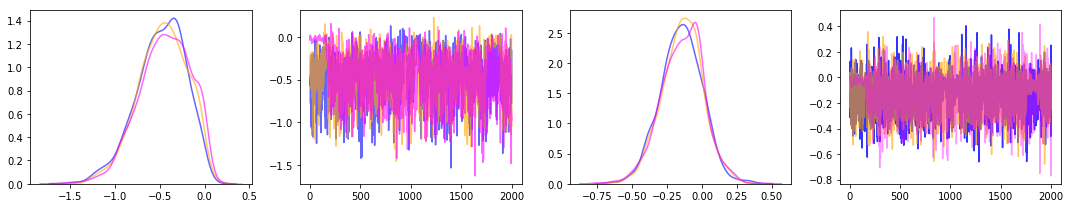

In [45]:
plt.subplots(figsize=(15,3))

plt.subplot(1,4,1)
sns.kdeplot(beta11[chain1], color='blue', alpha=0.6)
sns.kdeplot(beta11[chain2], color='orange', alpha=0.6)
sns.kdeplot(beta11[chain3], color='magenta', alpha=0.6)


plt.subplot(1,4,2)
plt.plot(chain_idx[chain1], beta11[chain1], color='blue', alpha=0.6)
plt.plot(chain_idx[chain2], beta11[chain2], color='orange', alpha=0.6)
plt.plot(chain_idx[chain3], beta11[chain3], color='magenta', alpha=0.6)

plt.subplot(1,4,3)
sns.kdeplot(beta12[chain1], color='blue', alpha=0.6)
sns.kdeplot(beta12[chain2], color='orange', alpha=0.6)
sns.kdeplot(beta12[chain3], color='magenta', alpha=0.6)


plt.subplot(1,4,4)
plt.plot(chain_idx[chain1], beta12[chain1], color='blue', alpha=0.8)
plt.plot(chain_idx[chain2], beta12[chain2], color='orange', alpha=0.6)
plt.plot(chain_idx[chain3], beta12[chain3], color='magenta', alpha=0.4)


plt.tight_layout()
plt.savefig('../Results/example_beta_traceplot_allZ_sc.png')
plt.show()